# Visualizing Embeddings

FiftyOne provides a powerful [embeddings visualization](https://voxel51.com/docs/fiftyone/user_guide/brain.html#visualizing-embeddings) capability that you can use to generate low-dimensional representations of the samples and objects in your datasets.

This notebook demonstrates applications of visualizing embeddings on several datasets, with the goal of motivating some the many possible workflows that you can perform.

Specifically, we'll cover the following concepts:

- Loading datasets from the [FiftyOne Dataset Zoo](https://voxel51.com/docs/fiftyone/user_guide/dataset_zoo_datasets.html)
- Using [compute_visualization()](https://voxel51.com/docs/api/fiftyone.brain.html?fiftyone.brain.compute_visualization#fiftyone.brain.compute_visualization) to generate 2D representations
- Providing custom embeddings to [compute_visualization()](https://voxel51.com/docs/api/fiftyone.brain.html?fiftyone.brain.compute_visualization#fiftyone.brain.compute_visualization)
- Visualizing embeddings via [interactive plots](https://voxel51.com/docs/fiftyone/user_guide/plots.html) connected to the [FiftyOne App](https://voxel51.com/docs/fiftyone/user_guide/app.html)

and we'll touch on how to use embeddings to:

- Identify anomolous/incorrect labels and predictions
- Find examples of scenarios of interest
- Pre-annotate unlabeled data for training
- Recommend samples from your data lake to augment your training dataset

**So, what's the takeaway?**

Combing through individual images/videos in a dataset and staring at aggregate performance metrics trying to figure out how to improve the performance of your model is in ineffective and time-consuming process. Visualizing your dataset in a low-dimensional embedding space is a powerful workflow that can reveal patterns and clusters in your data that can answer important questions about the critical failure modes of your model and how to augment your dataset to address these failures.

Using the FiftyOne Brain's [embeddings visualization](https://voxel51.com/docs/fiftyone/user_guide/brain.html#visualizing-embeddings) capability on your ML projects can help you uncover hidden patterns in your data and take action to improve the quality of your datasets and models.

![embeddings-sizzle](images/mnist-interactive1.gif)

## Setup

If you haven’t already, install FiftyOne:

In [ ]:
!pip install fiftyone

In this tutorial, we'll use some PyTorch models to generate embeddings, and we'll use the (default) [UMAP method](https://github.com/lmcinnes/umap) to generate embeddings, so we'll need also need to install the corresponding packages:

In [ ]:
!pip install torch torchvision umap-learn

This tutorial will demonstrate the powerful [interactive plotting](https://voxel51.com/docs/fiftyone/user_guide/plots.html) capabilities of FiftyOne.

The recommended way to work with FiftyOne's interactive plots is in [Jupyter notebooks](https://jupyter.org) or [JupyterLab](https://jupyterlab.readthedocs.io/en/stable), because, in these environments, you can leverage the full power of plots by [attaching them to the FiftyOne App](https://voxel51.com/docs/fiftyone/user_guide/plots.html#attaching-plots) and bidirectionally interacting with the plots and the App to identify interesting subsets of your data.

To use interactive plots in Jupyter notebooks, ensure that you have the ``ipywidgets`` package installed:

In [ ]:
!pip install ipywidgets>=7.5

If you're working in JupyterLab, refer to [these instructions](https://voxel51.com/docs/fiftyone/user_guide/plots.html#working-in-notebooks) to get setup.

> Support for interactive plots in non-notebook contexts and in [Google Colab](https://colab.research.google.com)
> is coming soon! In the meantime, you can still use FiftyOne's plotting features in these environments, but you
> must manually call `plot.show()` to update the state of a plot to match the state of a connected session, and
> any callbacks that would normally be triggered in response to interacting with a plot will not be triggered.

## Part I: MNIST

In this section, we'll be working with the [MNIST dataset](https://voxel51.com/docs/fiftyone/user_guide/dataset_zoo/datasets.html?highlight=mnist#dataset-zoo-mnist) from the dataset zoo:

In [5]:
import fiftyone as fo
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset("mnist")

Split 'train' already downloaded
Split 'test' already downloaded
Loading 'mnist' split 'train'
 100% |█████████████| 60000/60000 [1.5m elapsed, 0s remaining, 675.2 samples/s]      
Loading 'mnist' split 'test'
 100% |█████████████| 10000/10000 [6.9s elapsed, 0s remaining, 1.5K samples/s]      
Dataset 'mnist' created


Specifically, we'll start with the test split (10,000 images):

In [6]:
test_split = dataset.match_tags("test")

In [7]:
print(test_split)

Dataset:        mnist
Media type:     image
Num samples:    10000
Tags:           ['test']
Sample fields:
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
View stages:
    1. MatchTags(tags=['test'])


### Computing image embeddings

Typically (and in the rest of this tutorial) when generating low-dimensional representations of image datasets to visualize, one will use a deep model to generate embeddings for each image, say 1024 or 2028 dimensional, that are then passed to a dimensionality reduction method like [UMAP](https://github.com/lmcinnes/umap) or [t-SNE](https://lvdmaaten.github.io/tsne) to generate the 2D or 3D representation that is visualized.

Such an intermediate embedding step is necessary when the images in the dataset have different sizes, or are too large for [UMAP](https://github.com/lmcinnes/umap) or [t-SNE](https://lvdmaaten.github.io/tsne) to directly process, or the dataset is too complex and a model trained to recognize the concepts of interest is required in order to produce interpretable embeddings.

However, for a relatively small and fixed size dataset such as MNIST, we can try passing the images themselves to the dimensionality reduction method.

Let's use the [compute_visualization()](https://voxel51.com/docs/api/fiftyone.brain.html?fiftyone.brain.compute_visualization#fiftyone.brain.compute_visualization) method to generate our first representation:

In [9]:
import cv2
import numpy as np

import fiftyone.brain as fob

# Construct a ``num_samples x num_pixels`` array of images
embeddings = np.array([
    cv2.imread(f, cv2.IMREAD_UNCHANGED).ravel()
    for f in test_split.values("filepath")
])

# Compute 2D representation
results = fob.compute_visualization(
    test_split,
    embeddings=embeddings,
    num_dims=2,
    method="umap",
    brain_key="mnist_test",
    verbose=True,
    seed=51,
)

Generating visualization...
UMAP(dens_frac=0.0, dens_lambda=0.0, random_state=51, verbose=True)
Construct fuzzy simplicial set
Fri Apr  2 10:51:47 2021 Finding Nearest Neighbors
Fri Apr  2 10:51:47 2021 Building RP forest with 10 trees
Fri Apr  2 10:51:48 2021 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations
Fri Apr  2 10:52:02 2021 Finished Nearest Neighbor Search
Fri Apr  2 10:52:04 2021 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Fri Apr  2 10:52:22 2021 Finished embedding


The method returned a `results` object with a `points` attribute that contains a `10000 x 2` array of 2D embeddings for our samples that we'll visualize next.

In [13]:
print(type(results))
print(results.points.shape)

<class 'fiftyone.brain.visualization.VisualizationResults'>
(10000, 2)


### About `compute_visualization()`

There are two primary components to an embedding visualization: the method used to generate the embeddings, and the dimensionality reduction method used to compute a low-dimensional representation of the embeddings.

The ``embeddings`` and ``model`` parameters of
[compute_visualization()](https://voxel51.com/docs/api/fiftyone.brain.html?fiftyone.brain.compute_visualization#fiftyone.brain.compute_visualization) support a variety of ways to generate embeddings for your data:

- Provide nothing, in which case a default general purpose model is used to embed your data
- Provide a [Model instance](https://voxel51.com/docs/fiftyone/api/fiftyone.core.models.html#fiftyone.core.models.Model) or the name of any model from the [model zoo](https://voxel51.com/docs/fiftyone/user_guide/model_zoo/index.html) that supports embeddings
- Compute your own embeddings and provide them in array form
- Specify the name of a `VectorField` or `ArrayField` of your dataset in which your embeddings are stored

The ``method`` parameter of [compute_visualization()](https://voxel51.com/docs/api/fiftyone.brain.html?fiftyone.brain.compute_visualization#fiftyone.brain.compute_visualization) allows you to specify the dimensionality reduction method to use. The supported methods are:

- `"umap"` (default): [UMAP](https://github.com/lmcinnes/umap)
- `"t-sne"`: [t-SNE](https://lvdmaaten.github.io/tsne)
- `"pca"`: standard [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

### Visualizing embeddings

Now we're ready to use [results.visualize()](https://voxel51.com/docs/fiftyone/api/fiftyone.brain.visualization.html#fiftyone.brain.visualization.VisualizationResults.visualize) to visualize our representation.

Although we could use this method in isolation, the real power of FiftyOne comes when you [attach plots to the FiftyOne App](https://voxel51.com/docs/fiftyone/user_guide/plots.html#attaching-plots), so that when points of interest are selected in the plot, the corresponding samples/labels are automatically selected in the App, and vice versa.

So, let's open the test split in the App:


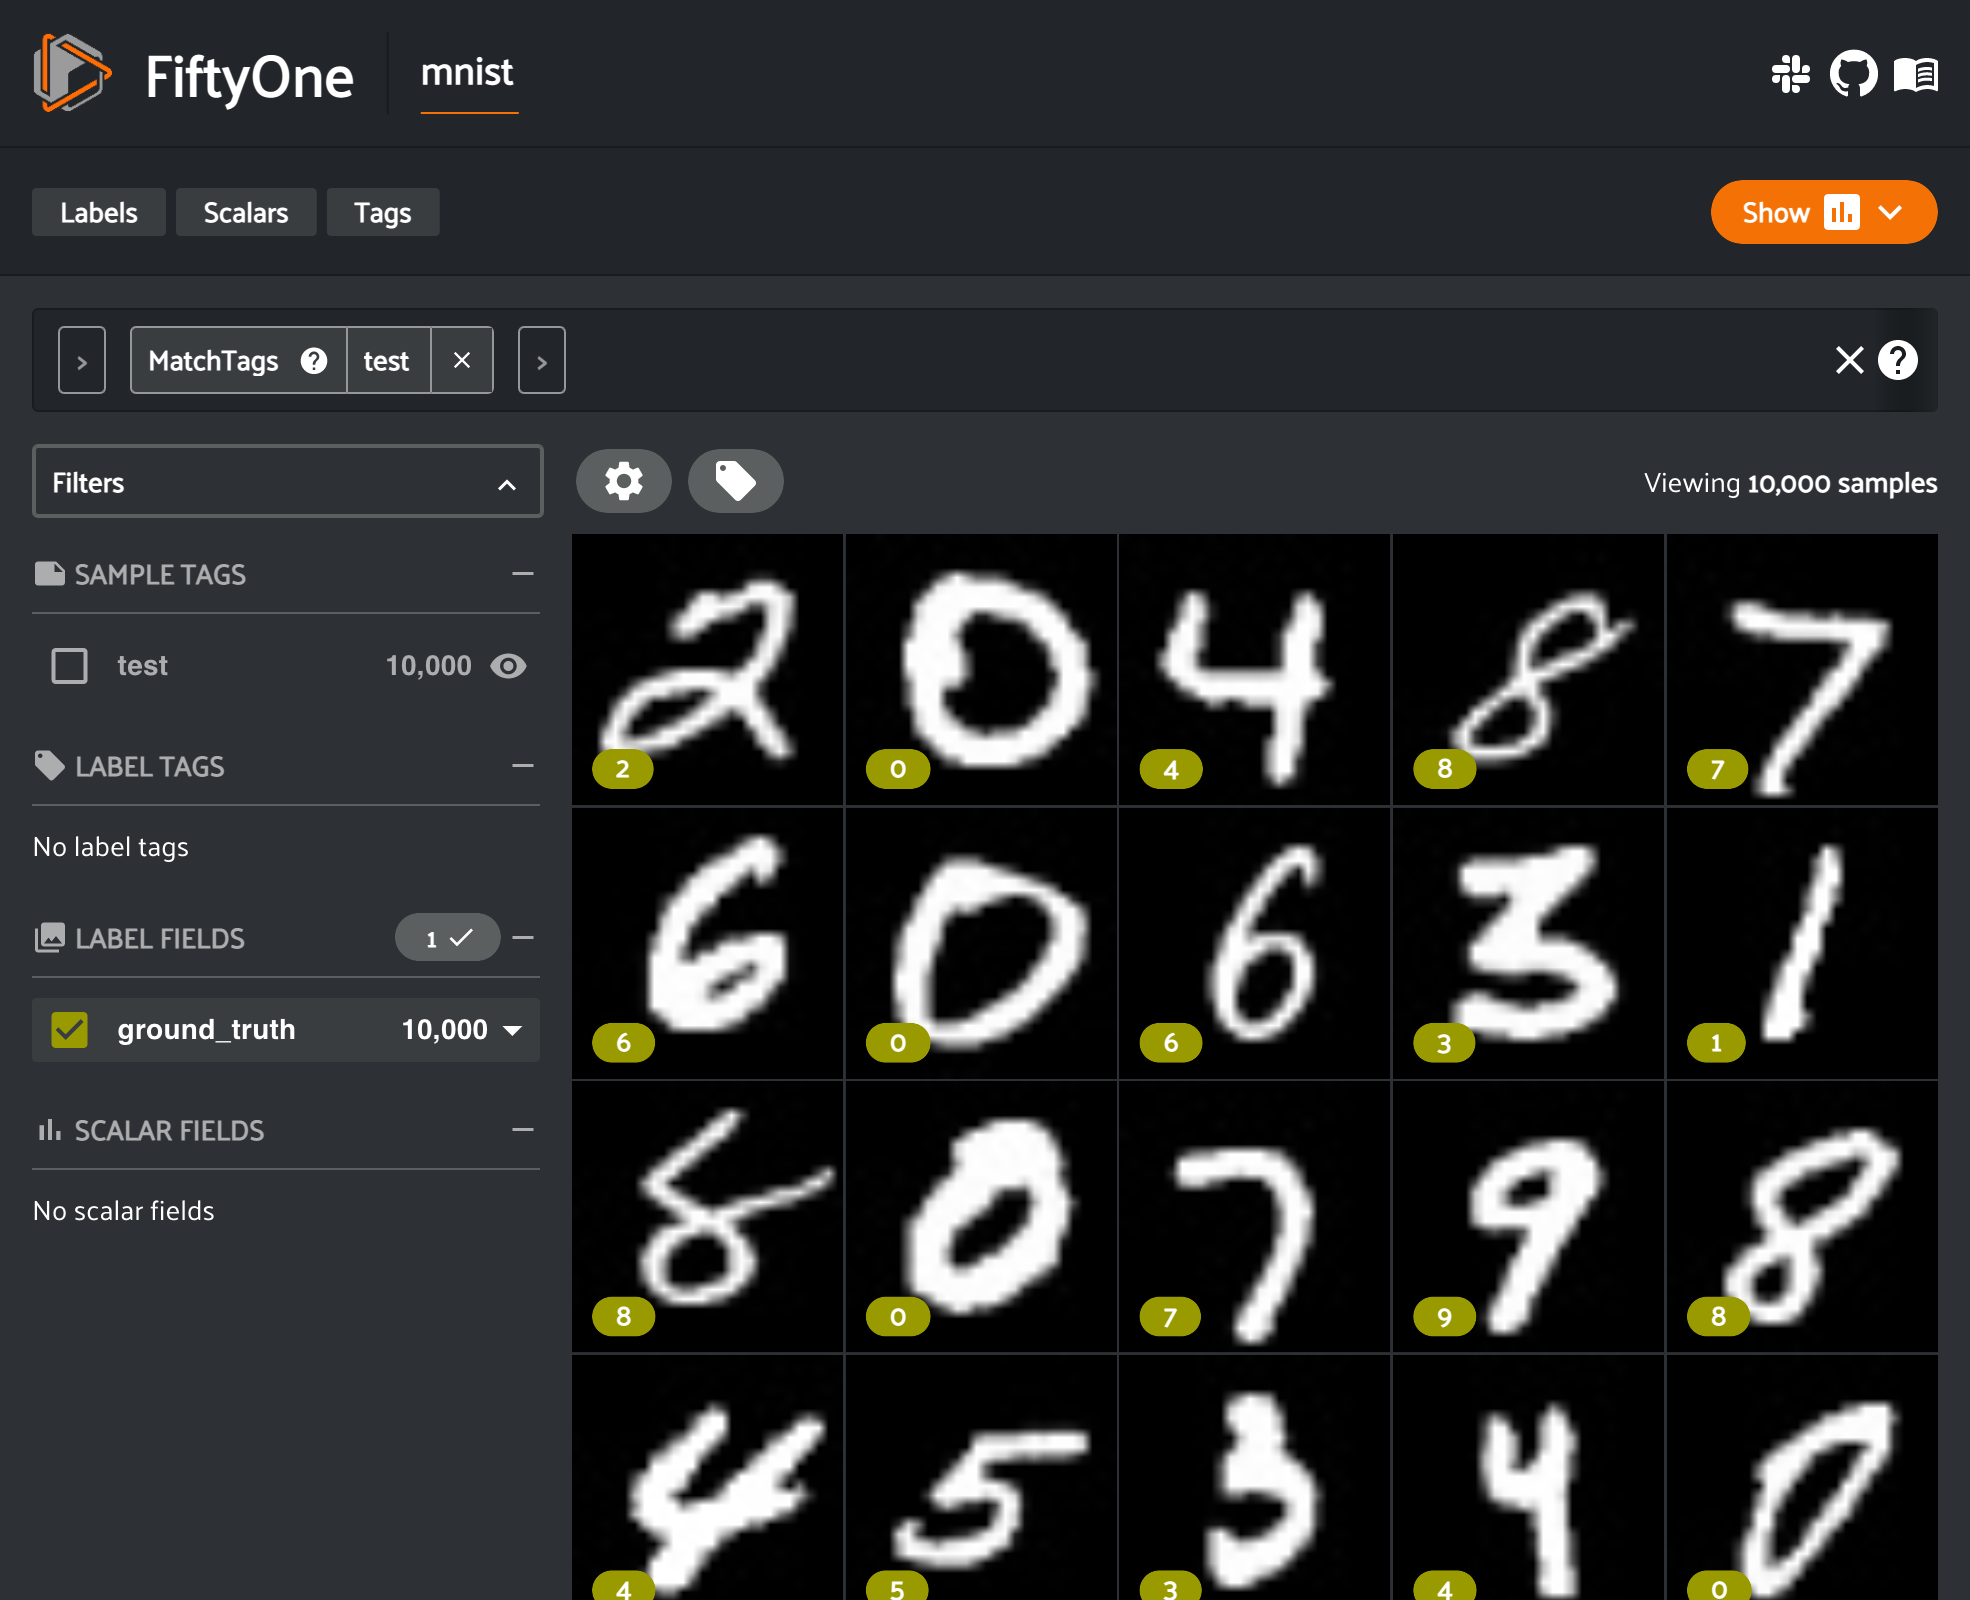

In [14]:
# Launch App instance
session = fo.launch_app(view=test_split)

Now let's visualize the results, colored by ground truth label, and attach the plot to our `session`:

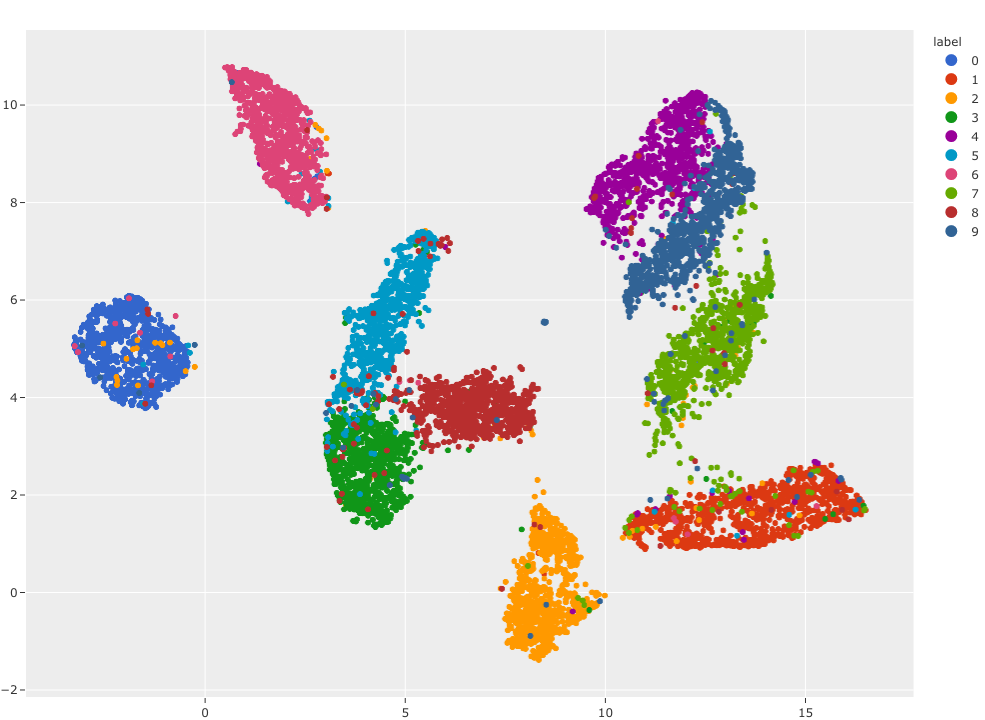

FigureWidget({
    'data': [{'customdata': array(['60672caaa9798a220de5bb88', '60672caaa9798a220de5bb8d',
    …

In [15]:
# Plot embeddings colored by ground truth label
plot = results.visualize(labels="ground_truth.label")
plot.show(height=720)

# Attach plot to session
session.plots.attach(plot)

Notice that the scatterpoints are naturally clustered by color (ground truth label), which means that [UMAP](https://github.com/lmcinnes/umap) was able to capture the visual differences between the digits!

### Scatterplot controls

Now it's time to explore the scatterplot interactively. Hover over the upper right corner of the plot to reveal the modebar, which provides two basic types of modes:
- The `Zoom`, `Pan`, `Zoom In`, `Zoom Out`, `Autoscale`, and `Reset axes` modes can be used to manipulate your current view
- The `Box Select` and `Lasso Select` modes enable you to select points in the plot

In `Box Select` or `Lasso Select` mode, drawing on the plot will select the points within the region you define. In addition, note that you can:
- Hold shift to add a region to your selection
- Double-click anywhere on the plot to deselect all points

Furthermore, since we chose a categorical label for the points, each ground truth label is given its own trace in the legend on the righthand side. You can interact with this legend to show/hide data:
- Single-click on a trace to show/hide all points in that trace
- Double-click on a trace to show/hide all *other* traces

### Exploring the embeddings

Here's a couple suggestions for exploring the data:

- Use `Lasso Select` to select the cluster of points corresponding to the `0` label. Note that the corresponding images loaded in the App are all images of zeros, as expected
- Try selecting other clusters and viewing the images in the App
- Click on the `0` label in the legend to hide the zeros. Now lasso the points from other traces that are in the `0` cluster. These are non-zero images in the dataset that are likley to be confused as zeros!

![mnist-interactive1](images/mnist-interactive1.gif)

Now try double-clicking on the `0` legend entry so that only the `0` points are visible in the plot. Then use the `Lasso Select` to select the `0` points that are far away from the main `0` cluster. These are zero images in the dataset that are likely to be confused as non-zeroes by a model!

![mnist-interactive2](images/mnist-interactive2.gif)

Cool, right!? It is clear that [compute_visualization()](https://voxel51.com/docs/api/fiftyone.brain.html?fiftyone.brain.compute_visualization#fiftyone.brain.compute_visualization) has picked up on some interesting structure in the test split of the dataset.

In [19]:
session.freeze()  # screenshots App and plot for sharing

### Pre-annotation of samples

Now let's put the insights from the previous section to work.

Imagine that you are [Yann LeCun](http://yann.lecun.com) or [Corinna Cortes](https://research.google/people/author121/), the creators of the MNIST dataset, and you have just invested the time to annotate the test split of the dataset by hand. Now, you have collected an additional 60K images of unlabeled digits that you want to use as a training split that you need to annotate.

Let's see how [compute_visualization()](https://voxel51.com/docs/api/fiftyone.brain.html?fiftyone.brain.compute_visualization#fiftyone.brain.compute_visualization) can be used to efficiently pre-annotate the train split with minimal effort.

First, let's regenerate embeddings for all 70,000 images in the `test + train` splits:

In [17]:
# Construct a ``num_samples x num_pixels`` array of images
embeddings = np.array([
    cv2.imread(f, cv2.IMREAD_UNCHANGED).ravel()
    for f in dataset.values("filepath")
])

# Compute 2D representation
results = fob.compute_visualization(
    dataset,
    embeddings=embeddings,
    num_dims=2,
    method="umap",
    brain_key="mnist",
    verbose=True,
    seed=51,
)

Generating visualization...
UMAP(dens_frac=0.0, dens_lambda=0.0, random_state=51, verbose=True)
Construct fuzzy simplicial set
Fri Apr  2 11:39:06 2021 Finding Nearest Neighbors
Fri Apr  2 11:39:06 2021 Building RP forest with 18 trees
Fri Apr  2 11:39:10 2021 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Fri Apr  2 11:39:13 2021 Finished Nearest Neighbor Search
Fri Apr  2 11:39:13 2021 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Apr  2 11:40:08 2021 Finished embedding


Of course, our `dataset` already has ground truth labels for the `train` split, but let's pretend that's not the case and generate an array of `labels` for our visualization that colors the test split by its ground truth label and assigns the `unlabeled` value to all images from the train split:

In [20]:
from fiftyone import ViewField as F

# Label `test` split samples by their ground truth label
# Give all samples in `train` split the label `unlabeled`
expr = F("$tags").contains("test").if_else(F("label"), "unlabeled")
labels = dataset.values("ground_truth", expr=expr)


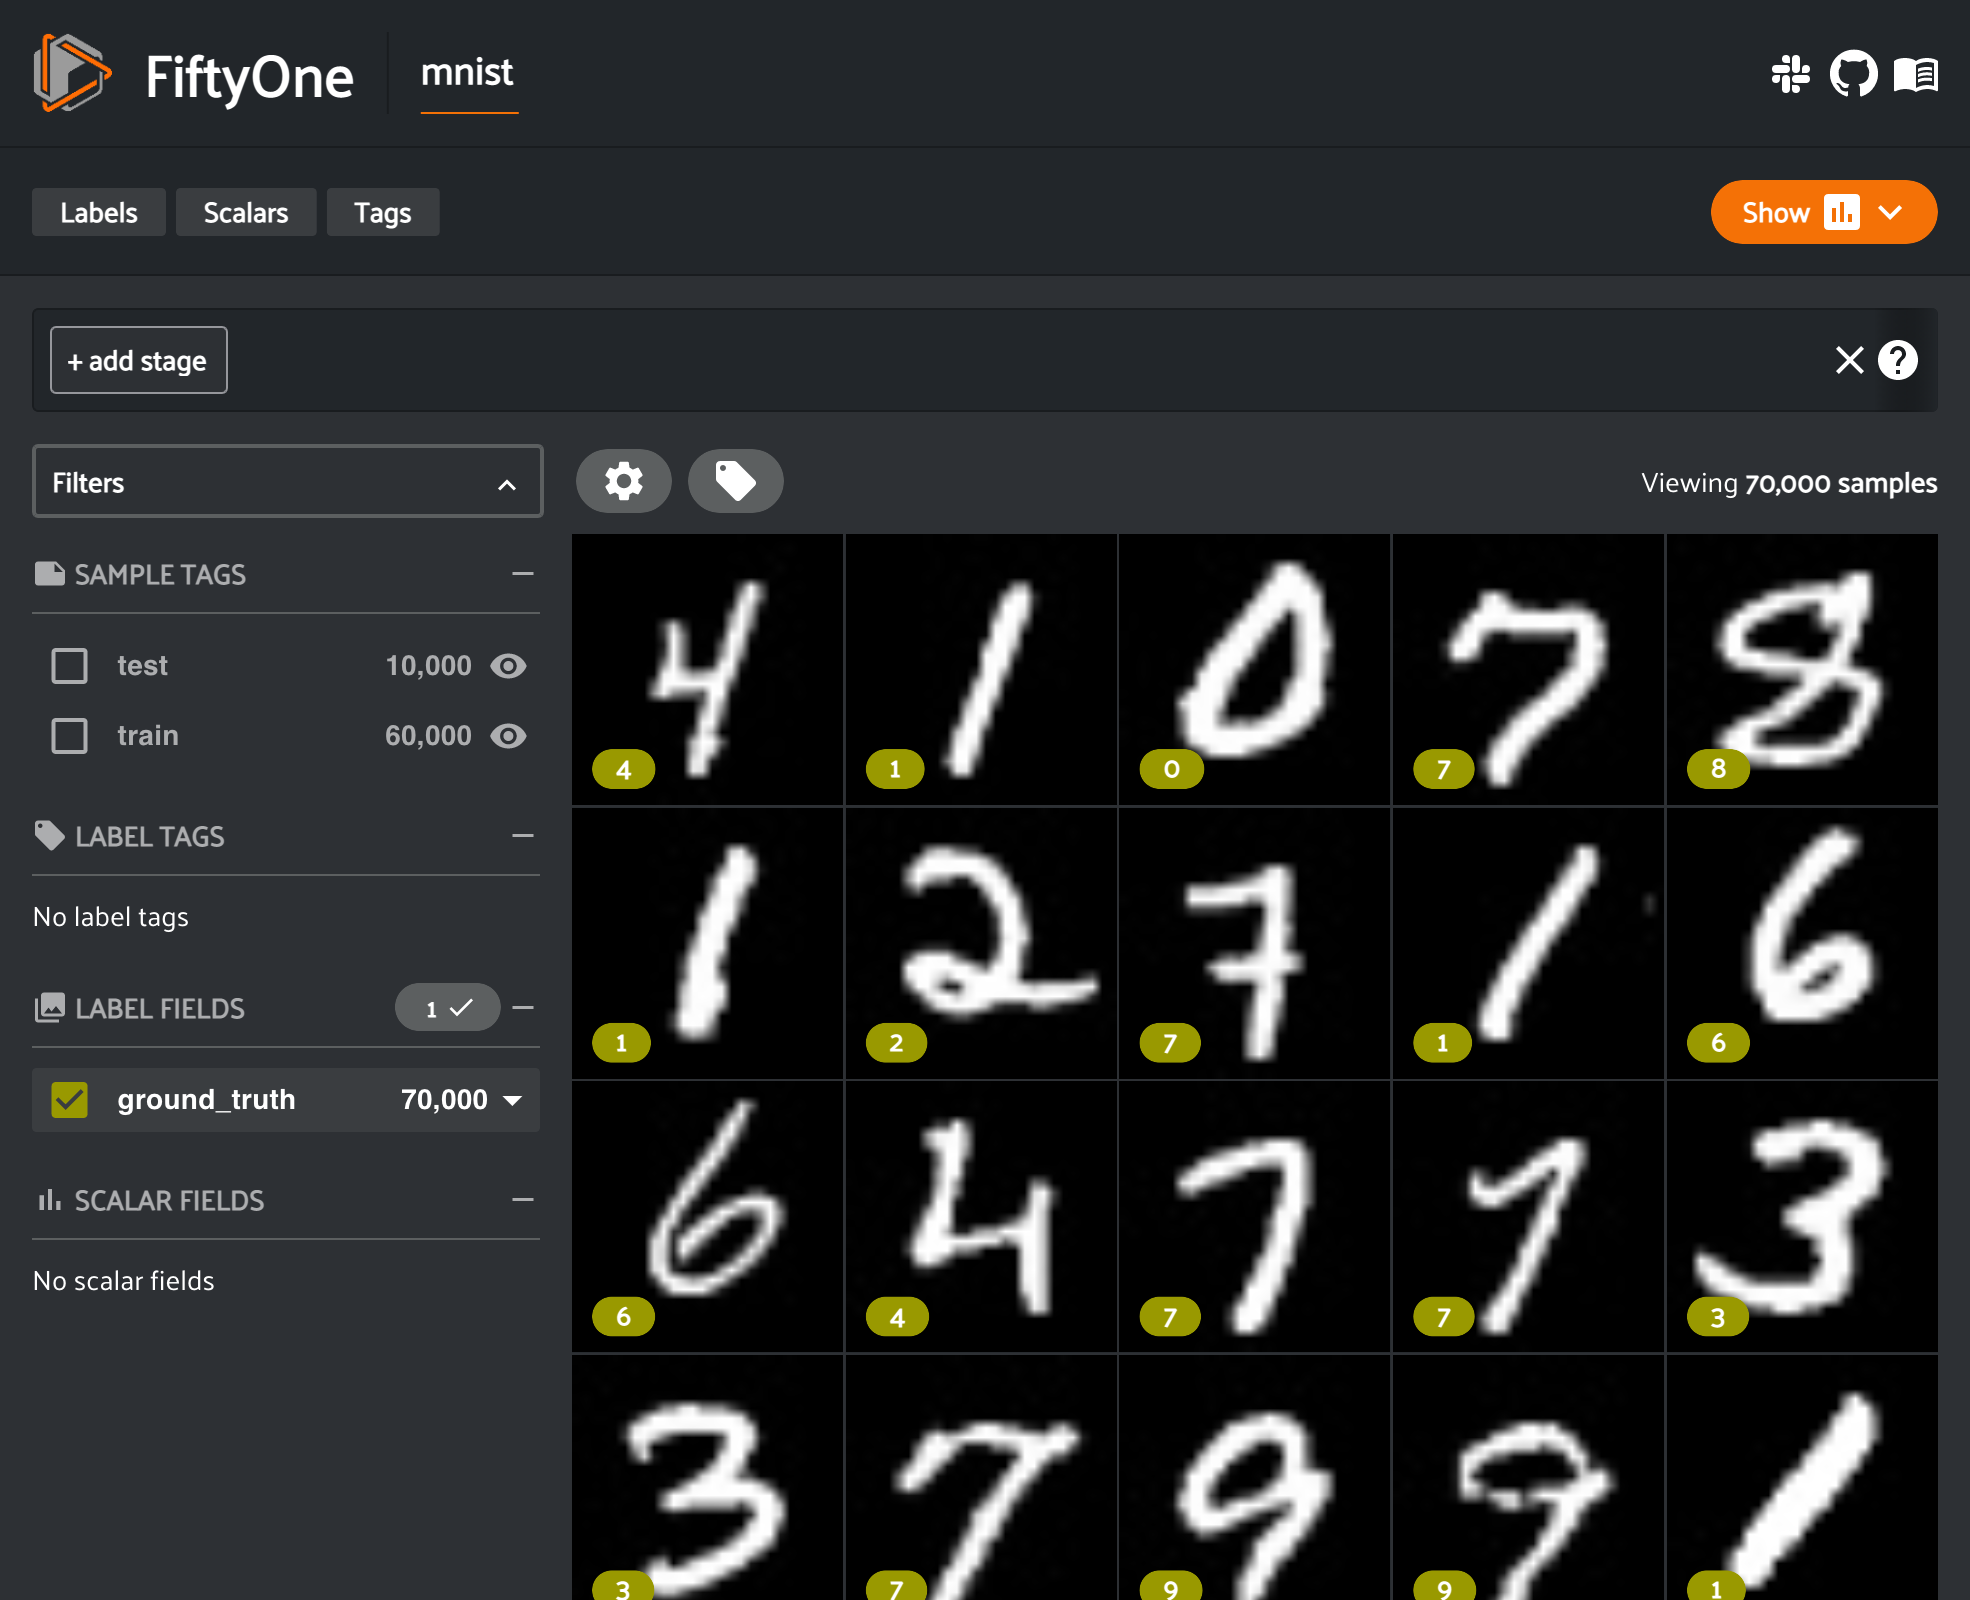

In [22]:
# Launch a new App instance
session = fo.launch_app(dataset)

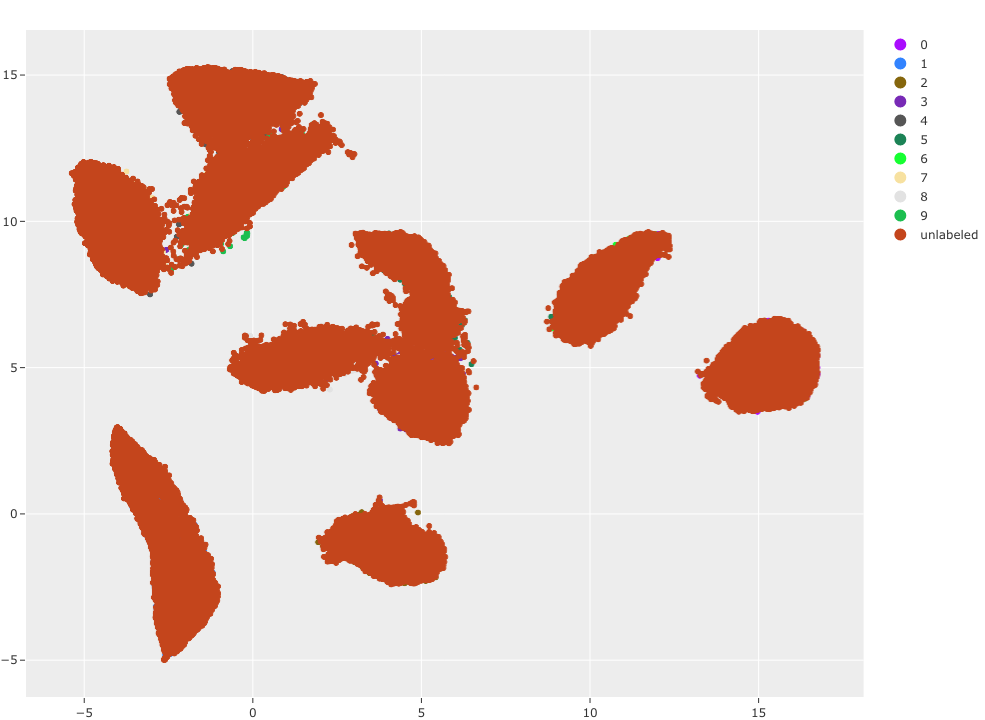

FigureWidget({
    'data': [{'customdata': array(['60672caaa9798a220de5bb88', '60672caaa9798a220de5bb8d',
    …

In [23]:
# Visualize results
plot = results.visualize(labels=labels)
plot.show(height=720)

# Attach plot to session
session.plots.attach(plot)

In [24]:
session.freeze()